## Assignment 06

#### Submitted By:
1. Dhruvan Ganesh
2. Sheikh Mastura Farzana

In [1]:
%load_ext tensorboard

### Environment Information
---

In [2]:
import torch.cuda
from pytorch_lightning import seed_everything
from torch import device

device = device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)
if torch.cuda.is_available():
    print("Device Name:", torch.cuda.get_device_name(0))

seed = 42
seed_everything(seed)
print("Set Random Seed:", seed)

data_dir = "~/.datasets"
print("Data Dir:", data_dir)

Device: cuda:0
Device Name: GeForce GTX 1660 Ti
Set Random Seed: 42
Data Dir: ~/.datasets


## <span style="font-variant:small-caps">Task 5.1: Denoising CAE on Robot Data</span>
---

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def get_kwargs(**kwargs):
    return kwargs

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation="nearest")
    plt.show()

In [4]:
import torch
from pytorch_lightning import LightningModule

import torch.nn as nn

In [5]:
class ConvolutionalEncoder(nn.Module):
    @staticmethod
    def _conv_block(
        in_channels, out_channels, kernel_size, stride=1, padding=0, batch_norm=True
    ):
        block = [
            nn.Conv2d(
                in_channels, out_channels, kernel_size, padding=padding, stride=stride
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ]
        if not batch_norm:
            block = block[:-1]
        return block

    def __init__(self, batch_size, color_channels):
        super().__init__()

        self.batch_size = batch_size
        self.layer1 = nn.Sequential(
            *self._conv_block(color_channels, 32, 3, padding=1),
            *self._conv_block(32, 32, 3, padding=1),
            nn.MaxPool2d(2, 2),                         # 128 x 128
            *self._conv_block(32, 64, 3, padding=1),
            *self._conv_block(64, 64, 3, padding=1),
            nn.MaxPool2d(2, 2),                         # 64 x 64
        )
        self.layer2 = nn.Sequential(
            *self._conv_block(64, 128, 3, padding=1),
            nn.MaxPool2d(2, 2),                         # 32 x 32
            *self._conv_block(128, 128, 3, padding=1),
            nn.MaxPool2d(2, 2),                         # 16 x 16
            *self._conv_block(128, 256, 3, padding=1, batch_norm=False),    # b x 256 x 16 x 16
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(self.batch_size, -1)
        return out

In [6]:
class ConvolutionalDecoder(nn.Module):
    @staticmethod
    def _conv_t_block(
        in_channels,
        out_channels,
        kernel_size,
        stride=1,
        padding=0,
        output_padding=0,
        batch_norm=True,
    ):
        block = [
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                padding=padding,
                stride=stride,
                output_padding=output_padding,
            ),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
        ]
        if not batch_norm:
            block = block[:-1]
        return block

    def __init__(self, batch_size, color_channels):
        super().__init__()

        self.batch_size = batch_size
        self.layer1 = nn.Sequential(
            *self._conv_t_block(256, 128, 3, 2, 1, 1),
            *self._conv_t_block(128, 128, 3, 1, 1),
            *self._conv_t_block(128, 64, 3, 2, 1, 1),
            *self._conv_t_block(64, 64, 3, 1, 1),
        )
        self.layer2 = nn.Sequential(
            *self._conv_t_block(64, 32, 3, 2, 1, 1),
            *self._conv_t_block(32, 32, 3, 1, 1),
            *self._conv_t_block(32, color_channels, 3, 2, 1, 1, batch_norm=False),
        )

    def forward(self, x):
        out = x.view(self.batch_size, 256, 16, 16)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [7]:
class ConvolutionalAutoEncoder(LightningModule):
    def __init__(self, batch_size, color_channels, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.encoder = ConvolutionalEncoder(
            batch_size=batch_size, color_channels=color_channels
        )
        self.decoder = ConvolutionalDecoder(
            batch_size=batch_size, color_channels=color_channels
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [8]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader


class RobotModule(LightningModule):
    def __init__(
        self, trainset_path: str, batch_size: int, validset_path=None, *args, **kwargs
    ):
        super().__init__(*args, **kwargs)
        self.preprocess = transforms.Compose(
            [
                transforms.Resize(256),
                transforms.CenterCrop(256),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
                ),
            ]
        )
        self.undo_preprocess = transforms.Normalize(
            mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
            std=[1 / 0.229, 1 / 0.224, 1 / 0.225],
        )

        self.trainset = datasets.ImageFolder(
            root=trainset_path, transform=self.preprocess
        )
        self.classes = self.trainset.classes
        if validset_path is None:
            validation_set_length = int(len(self.trainset) * 0.2)
            self.trainset, self.validset = torch.utils.data.random_split(
                self.trainset,
                [len(self.trainset) - validation_set_length, validation_set_length,],
            )
        else:
            self.validset = datasets.ImageFolder(
                root=validset_path, transform=self.preprocess
            )
        self.batch_size = batch_size
        self.color_channels = 3

    def train_dataloader(self):
        loader = DataLoader(
            self.trainset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=8,
            pin_memory=True,
            drop_last=True,
        )
        return loader

    def val_dataloader(self):
        loader = DataLoader(
            self.validset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=4,
            pin_memory=True,
            drop_last=True,
        )
        return loader

In [9]:
from torchvision import utils


def make_grid(tensors=(), idxs=()):
    out_tensors = []
    for tensor in tensors:
        for idx in idxs:
            out_tensors.append(tensor[idx])
    return out_tensors


class DenoisingCAERobot(RobotModule):
    def __init__(self, batch_size, **kwargs):
        super(DenoisingCAERobot, self).__init__(batch_size=batch_size, **kwargs)
        self.batch_size = batch_size
        self.model = ConvolutionalAutoEncoder(batch_size, self.color_channels)
        self.loss = nn.MSELoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.5)
        return [optimizer], [scheduler]

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_nb):
        x, y = batch
        x_n = torch.mul(x + 0.25, 0.1 * torch.rand(x.size()).to(self.device))
        out = self(x_n)
        loss = self.loss(out, x)
        tensorboard_logs = {"reconstruction_loss": loss.item()}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_nb):
        x, y = batch
        x_n = torch.mul(x + 0.25, 0.1 * torch.rand(x.size()).to(self.device))
        out = self(x_n)

        if batch_nb == 0 and self.current_epoch % 2 == 1:
            print(f"\nEpoch {self.current_epoch}:\n---------")
            grid_imgs = torch.stack(
                make_grid(
                    tensors=[x.detach(), x_n.detach(), out.detach(),], idxs=(0, 15, 16)
                ),
            )
            show(
                utils.make_grid(
                    grid_imgs, nrow=grid_imgs.size()[0] // 3, normalize=True,
                ).cpu()
            )

        return {"val_loss": self.loss(out, x)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_reconstruction_loss": avg_loss.item()}
        return {"val_loss": avg_loss, "log": tensorboard_logs}

In [10]:
from os import path

from pytorch_lightning import Trainer
from pytorch_lightning.loggers import TensorBoardLogger


def train_model_or_load_checkpoint(
    model_clazz: LightningModule,
    checkpoint_path: str,
    max_epochs: int,
    tensorboard_graph_name: str,
    device=device,
    **model_params
):
    if path.exists(checkpoint_path):
        print("Found pre-trained model!\nLoading Model...")
        model = model_clazz.load_from_checkpoint(checkpoint_path, **model_params)
        model = model.to(device)
        print("Loaded Model")
        return model
    else:
        model = model_clazz(**model_params)
        print("Begin Training...")
        logger = TensorBoardLogger("lightning_logs", name=tensorboard_graph_name)
        trainer = Trainer(
            checkpoint_callback=False,
            logger=logger,
            gpus=1,
            num_nodes=1,
            deterministic=True,
            max_epochs=max_epochs,
            progress_bar_refresh_rate=0,
            progress_bar_callback=False
        )
        trainer.fit(model)
        print("Training Complete")
        if "invalid" not in checkpoint_path:
            trainer.save_checkpoint(checkpoint_path)
            print("Saving Checkpoint")
        return model

In [11]:
%tensorboard --logdir lightning_logs/robot_cae/deconv_denoised_cae

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]


Begin Training...



   | Name                    | Type                     | Params
-----------------------------------------------------------------
0  | model                   | ConvolutionalAutoEncoder | 1 M   
1  | model.encoder           | ConvolutionalEncoder     | 583 K 
2  | model.encoder.layer1    | Sequential               | 65 K  
3  | model.encoder.layer1.0  | Conv2d                   | 896   
4  | model.encoder.layer1.1  | ReLU                     | 0     
5  | model.encoder.layer1.2  | BatchNorm2d              | 64    
6  | model.encoder.layer1.3  | Conv2d                   | 9 K   
7  | model.encoder.layer1.4  | ReLU                     | 0     
8  | model.encoder.layer1.5  | BatchNorm2d              | 64    
9  | model.encoder.layer1.6  | MaxPool2d                | 0     
10 | model.encoder.layer1.7  | Conv2d                   | 18 K  
11 | model.encoder.layer1.8  | ReLU                     | 0     
12 | model.encoder.layer1.9  | BatchNorm2d              | 128   
13 | model.encoder.laye


Epoch 1:
---------


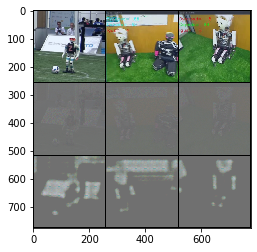


Epoch 3:
---------


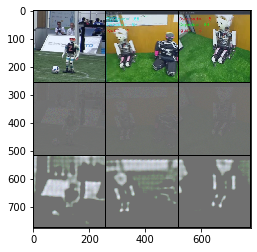


Epoch 5:
---------


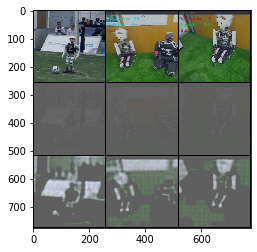


Epoch 7:
---------


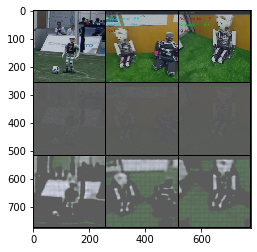


Epoch 9:
---------


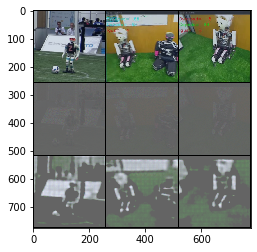


Epoch 11:
---------


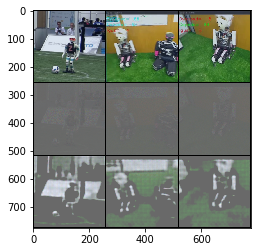


Epoch 13:
---------


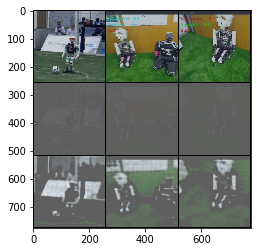


Epoch 15:
---------


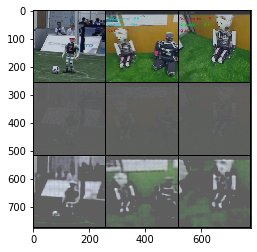


Epoch 17:
---------


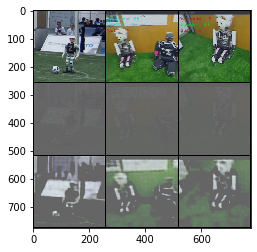


Epoch 19:
---------


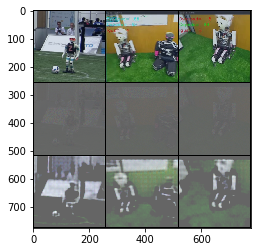


Epoch 21:
---------


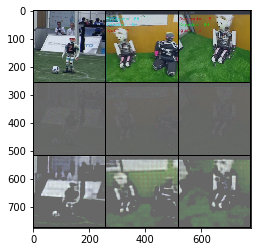


Epoch 23:
---------


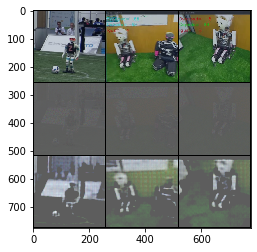

Training Complete


In [12]:
model_params = get_kwargs(
    batch_size=32, trainset_path="robot_dataset/cropped"
)

robot_cae = train_model_or_load_checkpoint(
    model_clazz=DenoisingCAERobot,
    checkpoint_path="dcae_robot.ckpt/invalid",
    max_epochs=25,
    tensorboard_graph_name="robot_cae/deconv_denoised_cae",
    **model_params
)

## <span style="font-variant:small-caps">Task 5.2: Use the latent space for Robot classification</span>
---

In [13]:
class LatentSpaceClassifierRobot(RobotModule):
    def __init__(self, batch_size, trainset_path, latent_space_encoder):
        super().__init__(batch_size=batch_size, trainset_path=trainset_path)
        self.batch_size = batch_size
        self.model = torch.nn.Sequential(
            nn.Linear(256 * 16 * 16, 256),
            nn.Dropout(0.2),
            nn.Linear(256, 84),
            nn.Dropout(0.2),
            nn.Linear(84, 10)
        )
        self.latent_space_encoder = latent_space_encoder.to(device)
        self.loss = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.latent_space_encoder(x)
        return self.model(x.view(x.size(0), -1))

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.loss(y_hat, y)
        labels_hat = torch.argmax(y_hat, dim=1)
        train_acc = torch.sum(y == labels_hat).item() / (len(y) * 1.0)
        tensorboard_logs = {"train_loss": loss.item(), "train_acc": train_acc}
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)

        labels_hat = torch.argmax(y_hat, dim=1)
        val_acc = torch.sum(y == labels_hat).item() / (len(y) * 1.0)

        return {"val_loss": self.loss(y_hat, y), "val_acc": torch.tensor(val_acc)}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        avg_acc = torch.stack([x["val_acc"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss, "val_acc": avg_acc}
        return {"val_loss": avg_loss, "val_acc": avg_acc, "log": tensorboard_logs}

    @torch.no_grad()
    def get_all_preds(self):
        all_preds = torch.tensor([]).to(device)
        labels = torch.tensor([], dtype=torch.int64).to(device)
        for x, y in self.val_dataloader():
            x, y = x.to(device), y.to(device)
            y_hat = self.forward(x)
            all_preds = torch.cat((all_preds, y_hat), dim=0)
            labels = torch.cat((labels, y), dim=0)
        pred_labels = all_preds.argmax(dim=1)
        return pred_labels, labels

In [14]:
%tensorboard --logdir lightning_logs/robot_classification/latent_space_classifier

In [15]:
model_params = get_kwargs(
    batch_size=32,
    trainset_path="robot_dataset/cropped",
    latent_space_encoder=robot_cae.model.encoder,
)

latent_space_classifier_model = train_model_or_load_checkpoint(
    model_clazz=LatentSpaceClassifierRobot,
    checkpoint_path="latent_space_classifier_robot.ckpt",
    max_epochs=20,
    tensorboard_graph_name="robot_classification/latent_space_classifier",
    **model_params
)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

   | Name                           | Type                 | Params
--------------------------------------------------------------------
0  | model                          | Sequential           | 16 M  
1  | model.0                        | Linear               | 16 M  
2  | model.1                        | Dropout              | 0     
3  | model.2                        | Linear               | 21 K  
4  | model.3                        | Dropout              | 0     
5  | model.4                        | Linear               | 850   
6  | latent_space_encoder           | ConvolutionalEncoder | 583 K 
7  | latent_space_encoder.layer1    | Sequential           | 65 K  
8  | latent_space_encoder.layer1.0  | Conv2d               | 896   
9  | latent_space_encoder.layer1.1  | ReLU                 | 0     
10 | latent_space_encoder.layer1.2  | BatchNorm2d          | 64    

Begin Training...
Training Complete


/home/navrudh/Apps/miniconda3/envs/cudavision/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


Saving Checkpoint


In [16]:
from sklearn.metrics import classification_report

y_pred, y_true = latent_space_classifier_model.get_all_preds()
y_pred, y_true = y_pred.cpu().numpy(), y_true.cpu().numpy()


print("\n==================\nValidation Report:\n==================")
print(
    classification_report(
        y_true, y_pred, target_names=latent_space_classifier_model.classes
    )
)

latent_space_classifier_model = None


Validation Report:
              precision    recall  f1-score   support

    no_robot       0.97      0.89      0.93        73
       robot       0.94      0.98      0.96       119

    accuracy                           0.95       192
   macro avg       0.95      0.94      0.94       192
weighted avg       0.95      0.95      0.95       192

